## Siemens PCA and FPCA as outlier detector

This code shows the implementation of PCA and FPCA for reducing the dimension of the multiple time series.
It adds the scores and identify the time series which contribute the most to the principal components. 
However, after some research the main benefit of this technique relies on visualization of two components which summarize all the curves and as outlier detection due to its sensibility to campture patterns in the data.

For instance, if commenting the block of code "Data cleaning - Removing unsuccessful return codes" and runing PCA and FPCA on "A1_cal_window" we can observe how the second component displays a peak. However, when removing the unsuccessful return codes as was suggested by Siemens in the meeting of May 17th, we can see this pattern dissapears. 

**Index**

1. Loading the datasets
2. Transposing the time series datasets
3. Merging time series datasets to add additional features
4. Identifying TestID with bad return codes
5. Data cleaning - Removing unsuccessful return codes
6. Filtering and spliting in Blood and Aquous groups
7. Window extraction
8. Removing partial or full series with missing values after the window extraction
9. Function to plot time series in one plot
10. PCA
11. Functional PCA
12. Verifying waveforms which contributes the most to PC's shape

## 1. Loading the datasets

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## 2. Transposing the time series datasets 

In [2]:
# import datasets
sensorA_System1 = pd.read_csv("RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("RawData/System2_SensorB.csv")
keyByTestID = pd.read_csv("RawData/Key by TestID.csv", parse_dates=['DateTime'])

## 3. Merging time series datasets to add additional features

In [3]:
# Transpose dataset to make columns as timestamps and rows as tests

# Sensor A
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

# Sensor B
B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [4]:
# Merge dataset with keyByTestID and delete unmatched tests
# Sensor A
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]

# Merge dataset with keyByTestID
# Sensor B
B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B2_transposed = B2_transposed[B2_transposed['TestID'].isin(B2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3407, 2694)
A2:  (7781, 1319)
B1:  (3398, 3376)
B2:  (7780, 3367)


## 4. Identifying TestID with bad return codes

In [5]:
A1_Merged_bad_returncodes = A1_Merged[~A1_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
A2_Merged_bad_returncodes = A2_Merged[~A2_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
B1_Merged_bad_returncodes = B1_Merged[~B1_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
B2_Merged_bad_returncodes = B2_Merged[~B2_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()

print('A1_Merged_bad_returncodes')
print(A1_Merged_bad_returncodes['TestID'])
print('\nA2_Merged_bad_returncodes\n')
print(A2_Merged_bad_returncodes['TestID'])
print('\nB1_Merged_bad_returncodes\n')
print(B1_Merged_bad_returncodes['TestID'])
print('\nB2_Merged_bad_returncodes\n')
print(B2_Merged_bad_returncodes['TestID'])

A1_Merged_bad_returncodes
0       12414199
44      12416289
48      12416278
122     12446029
201     12486850
492     12601278
728     12191442
995     12514810
1051    12515535
1091    12515705
1205    12480292
1207    12623120
1242    12597803
1355    12530207
1602    12530199
1915    12472338
2060    12530446
2071    12530379
2261    12557613
2301    12470796
2352    12529229
2374    12390613
2652    12371902
2826    12529328
3095    12531249
Name: TestID, dtype: int64

A2_Merged_bad_returncodes

608     3561473
859     3545381
1085    3547411
1258    3548457
1698    3553569
1728    3553619
1983    3555557
2258    3557972
2497    3561799
2688    3564315
2877    3565626
2889    3565643
2924    3565699
2944    3565740
3009    3565982
3039    3566065
3046    3566584
3072    3566624
3115    3566834
3117    3566837
3118    3566838
3171    3566963
3806    3552740
3921    3552653
4039    3569098
5523    3555888
5577    3555913
5608    3558047
6242    3558380
6950    3567852
7145    355160

## 5. Data cleaning - Removing unsuccessful return codes

In [6]:
A1_Merged = A1_Merged[A1_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
A2_Merged = A2_Merged[A2_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
B1_Merged = B1_Merged[B1_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
B2_Merged = B2_Merged[B2_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()

A1_Merged.reset_index(drop=True, inplace=True)
A2_Merged.reset_index(drop=True, inplace=True)
B1_Merged.reset_index(drop=True, inplace=True)
B2_Merged.reset_index(drop=True, inplace=True)

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3382, 2694)
A2:  (7743, 1319)
B1:  (3375, 3376)
B2:  (7745, 3367)


## 6. Filtering and spliting in Blood and Aquous groups

In [7]:
# Blood
A1_blood_Merged = A1_Merged[A1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A2_blood_Merged = A2_Merged[A2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A1_blood_Merged.reset_index(drop=True, inplace=True)
A2_blood_Merged.reset_index(drop=True, inplace=True)

# Aquous
A1_aquous_Merged = A1_Merged[~A1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A2_aquous_Merged = A2_Merged[~A2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A1_aquous_Merged.reset_index(drop=True, inplace=True)
A2_aquous_Merged.reset_index(drop=True, inplace=True)

# Blood
B1_blood_Merged = (B1_Merged[B1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B2_blood_Merged = (B2_Merged[B2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B1_blood_Merged.reset_index(drop=True, inplace=True)
B2_blood_Merged.reset_index(drop=True, inplace=True)

# Aquous
B1_aquous_Merged = (B1_Merged[~B1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B2_aquous_Merged = (B2_Merged[~B2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B1_aquous_Merged.reset_index(drop=True, inplace=True)
B2_aquous_Merged.reset_index(drop=True, inplace=True)

## 7. Window extraction

In [8]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Match window values of Sensor B for each test

# Blood
calDelLimit_sensorB_blood = 20
sampleDelLimit_sensorB_blood = 24
calWindowSize_sensorB_blood = 18
sampleWindowSize_sensorB_blood = 4

# Aquous
calDelLimit_sensorB_aqueous = 20
sampleDelLimit_sensorB_aqueous = 30
calWindowSize_sensorB_aqueous = 18
sampleWindowSize_sensorB_aqueous = 4

# Define a function to calculate window start and end values
def calculate_window_values(bubble_start, sample_start, calDelimit_input, cal_window_size_input, sampleDelimit_input, sample_window_size_input):
    cal_window_start = bubble_start - calDelimit_input
    cal_window_end = cal_window_start + cal_window_size_input
    sample_window_start = sample_start + sampleDelimit_input
    sample_window_end = sample_window_start + sample_window_size_input
    return cal_window_start, cal_window_end, sample_window_start, sample_window_end

# Sensor A
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end


# Sensor A - Blood
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_blood_Merged['cal_window_start']=cal_window_start
A1_blood_Merged['cal_window_end']=cal_window_end
A1_blood_Merged['sample_window_start']=sample_window_start
A1_blood_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_blood_Merged['cal_window_start']=cal_window_start
A2_blood_Merged['cal_window_end']=cal_window_end
A2_blood_Merged['sample_window_start']=sample_window_start
A2_blood_Merged['sample_window_end']=sample_window_end


# Sensor A - Aquous
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_aquous_Merged['cal_window_start']=cal_window_start
A1_aquous_Merged['cal_window_end']=cal_window_end
A1_aquous_Merged['sample_window_start']=sample_window_start
A1_aquous_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_aquous_Merged['cal_window_start']=cal_window_start
A2_aquous_Merged['cal_window_end']=cal_window_end
A2_aquous_Merged['sample_window_start']=sample_window_start
A2_aquous_Merged['sample_window_end']=sample_window_end

# Sensor B - Blood
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B1_blood_Merged['cal_window_start']=cal_window_start
B1_blood_Merged['cal_window_end']=cal_window_end
B1_blood_Merged['sample_window_start']=sample_window_start
B1_blood_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B2_blood_Merged['cal_window_start']=cal_window_start
B2_blood_Merged['cal_window_end']=cal_window_end
B2_blood_Merged['sample_window_start']=sample_window_start
B2_blood_Merged['sample_window_end']=sample_window_end


# Sensor B - Aquous
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B1_aquous_Merged['cal_window_start']=cal_window_start
B1_aquous_Merged['cal_window_end']=cal_window_end
B1_aquous_Merged['sample_window_start']=sample_window_start
B1_aquous_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B2_aquous_Merged['cal_window_start']=cal_window_start
B2_aquous_Merged['cal_window_end']=cal_window_end
B2_aquous_Merged['sample_window_start']=sample_window_start
B2_aquous_Merged['sample_window_end']=sample_window_end

In [9]:
# Define a function to extract window data of each test
def calculate_window_data(row):
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[18:-4].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window],row[sample_window]

# Sensor A

A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID']
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)

A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID']
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor A - Blood

A1_blood_cal_window = []
A1_blood_sample_window = []
for i in range(len(A1_blood_Merged)):
    cal_window, sample_window = calculate_window_data(A1_blood_Merged.iloc[i, :])
    A1_blood_cal_window.append(cal_window.values)
    A1_blood_sample_window.append(sample_window.values)
A1_blood_cal_window = pd.DataFrame(A1_blood_cal_window)
A1_blood_sample_window = pd.DataFrame(A1_blood_sample_window)
A1_blood_cal_window['TestID'] = A1_blood_sample_window['TestID'] = A1_blood_Merged['TestID']
A1_blood_sample_window.set_index('TestID',inplace=True)
A1_blood_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor A - Aquous

A1_aquous_cal_window = []
A1_aquous_sample_window = []
for i in range(len(A1_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(A1_aquous_Merged.iloc[i, :])
    A1_aquous_cal_window.append(cal_window.values)
    A1_aquous_sample_window.append(sample_window.values)
A1_aquous_cal_window = pd.DataFrame(A1_aquous_cal_window)
A1_aquous_sample_window = pd.DataFrame(A1_aquous_sample_window)
A1_aquous_cal_window['TestID'] = A1_aquous_sample_window['TestID'] = A1_aquous_Merged['TestID']
A1_aquous_sample_window.set_index('TestID',inplace=True)
A1_aquous_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A - Blood

A2_blood_cal_window = []
A2_blood_sample_window = []
for i in range(len(A2_blood_Merged)):
    cal_window, sample_window = calculate_window_data(A2_blood_Merged.iloc[i, :])
    A2_blood_cal_window.append(cal_window.values)
    A2_blood_sample_window.append(sample_window.values)
A2_blood_cal_window = pd.DataFrame(A2_blood_cal_window)
A2_blood_sample_window = pd.DataFrame(A2_blood_sample_window)
A2_blood_cal_window['TestID'] = A2_blood_sample_window['TestID'] = A2_blood_Merged['TestID']
A2_blood_sample_window.set_index('TestID',inplace=True)
A2_blood_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A - Aquous

A2_aquous_cal_window = []
A2_aquous_sample_window = []
for i in range(len(A2_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(A2_aquous_Merged.iloc[i, :])
    A2_aquous_cal_window.append(cal_window.values)
    A2_aquous_sample_window.append(sample_window.values)
A2_aquous_cal_window = pd.DataFrame(A2_aquous_cal_window)
A2_aquous_sample_window = pd.DataFrame(A2_aquous_sample_window)
A2_aquous_cal_window['TestID'] = A2_aquous_sample_window['TestID'] = A2_aquous_Merged['TestID']
A2_aquous_sample_window.set_index('TestID',inplace=True)
A2_aquous_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Blood

B1_blood_cal_window = []
B1_blood_sample_window = []
for i in range(len(B1_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B1_blood_Merged.iloc[i, :])
    B1_blood_cal_window.append(cal_window.values)
    B1_blood_sample_window.append(sample_window.values)
B1_blood_cal_window = pd.DataFrame(B1_blood_cal_window)
B1_blood_sample_window = pd.DataFrame(B1_blood_sample_window)
B1_blood_cal_window['TestID'] = B1_blood_sample_window['TestID'] = B1_blood_Merged['TestID']
B1_blood_sample_window.set_index('TestID',inplace=True)
B1_blood_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor B - Blood

B2_blood_cal_window = []
B2_blood_sample_window = []
for i in range(len(B2_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B2_blood_Merged.iloc[i, :])
    B2_blood_cal_window.append(cal_window.values)
    B2_blood_sample_window.append(sample_window.values)
B2_blood_cal_window = pd.DataFrame(B2_blood_cal_window)
B2_blood_sample_window = pd.DataFrame(B2_blood_sample_window)
B2_blood_cal_window['TestID'] = B2_blood_sample_window['TestID'] = B2_blood_Merged['TestID']
B2_blood_sample_window.set_index('TestID',inplace=True)
B2_blood_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Aquous

B1_aquous_cal_window = []
B1_aquous_sample_window = []
for i in range(len(B1_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(B1_aquous_Merged.iloc[i, :])
    B1_aquous_cal_window.append(cal_window.values)
    B1_aquous_sample_window.append(sample_window.values)
B1_aquous_cal_window = pd.DataFrame(B1_aquous_cal_window)
B1_aquous_sample_window = pd.DataFrame(B1_aquous_sample_window)
B1_aquous_cal_window['TestID'] = B1_aquous_sample_window['TestID'] = B1_aquous_Merged['TestID']
B1_aquous_sample_window.set_index('TestID',inplace=True)
B1_aquous_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Aquous

B2_aquous_cal_window = []
B2_aquous_sample_window = []
for i in range(len(B2_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(B2_aquous_Merged.iloc[i, :])
    B2_aquous_cal_window.append(cal_window.values)
    B2_aquous_sample_window.append(sample_window.values)
B2_aquous_cal_window = pd.DataFrame(B2_aquous_cal_window)
B2_aquous_sample_window = pd.DataFrame(B2_aquous_sample_window)
B2_aquous_cal_window['TestID'] = B2_aquous_sample_window['TestID'] = B2_aquous_Merged['TestID']
B2_aquous_sample_window.set_index('TestID',inplace=True)
B2_aquous_cal_window.set_index('TestID',inplace=True)

## 8. Removing partial or full series with missing values after the window extraction

In [10]:
# Drop TestId's with NA's
A1_cal_window.dropna(axis=0, inplace=True) 
A2_cal_window.dropna(axis=0, inplace=True) 

A1_blood_cal_window.dropna(axis=0, inplace=True)
A1_aquous_cal_window.dropna(axis=0, inplace=True)
A2_blood_cal_window.dropna(axis=0, inplace=True)
A2_aquous_cal_window.dropna(axis=0, inplace=True)

B1_blood_cal_window.dropna(axis=0, inplace=True)
B1_aquous_cal_window.dropna(axis=0, inplace=True)
B2_blood_cal_window.dropna(axis=0, inplace=True)
B2_aquous_cal_window.dropna(axis=0, inplace=True)

A1_sample_window.dropna(axis=0, inplace=True) 
A2_sample_window.dropna(axis=0, inplace=True) 

A1_blood_sample_window.dropna(axis=0, inplace=True)
A1_aquous_sample_window.dropna(axis=0, inplace=True)
A2_blood_sample_window.dropna(axis=0, inplace=True)
A2_aquous_sample_window.dropna(axis=0, inplace=True)

B1_blood_sample_window.dropna(axis=0, inplace=True)
B1_aquous_sample_window.dropna(axis=0, inplace=True)
B2_blood_sample_window.dropna(axis=0, inplace=True)
B2_aquous_sample_window.dropna(axis=0, inplace=True)


print('A1_cal: ', A1_cal_window.shape)
print('A2_cal: ',  A2_cal_window.shape)

print('A1_blood_cal_window: ', A1_blood_cal_window.shape)
print('A1_aquous_cal_window: ', A1_aquous_cal_window.shape)
print('A2_blood_cal_window: ', A2_blood_cal_window.shape)
print('A2_aquous_cal_window: ', A2_aquous_cal_window.shape)

print('B1_blood_cal_window: ', B1_blood_cal_window.shape)
print('B1_aquous_cal_window: ', B1_aquous_cal_window.shape)
print('B2_blood_cal_window: ', B2_blood_cal_window.shape)
print('B2_aquous_cal_window: ', B2_aquous_cal_window.shape)


print('A1_sample: ', A1_sample_window.shape)
print('A2_sample: ', A2_sample_window.shape)

print('A1_blood_sample_window: ', A1_blood_sample_window.shape)
print('A1_aquous_sample_window: ', A1_aquous_sample_window.shape)
print('A2_blood_sample_window: ', A2_blood_sample_window.shape)
print('A2_aquous_sample_window: ', A2_aquous_sample_window.shape)

print('B1_blood_sample_window: ', B1_blood_sample_window.shape)
print('B1_aquous_sample_window: ', B1_aquous_sample_window.shape)
print('B2_blood_sample_window: ', B2_blood_sample_window.shape)
print('B2_aquous_sample_window: ', B2_aquous_sample_window.shape)

A1_cal:  (3349, 41)
A2_cal:  (7557, 41)
A1_blood_cal_window:  (1916, 41)
A1_aquous_cal_window:  (1433, 41)
A2_blood_cal_window:  (4745, 41)
A2_aquous_cal_window:  (2812, 41)
B1_blood_cal_window:  (1944, 91)
B1_aquous_cal_window:  (1431, 91)
B2_blood_cal_window:  (4887, 91)
B2_aquous_cal_window:  (2852, 91)
A1_sample:  (3349, 26)
A2_sample:  (7535, 26)
A1_blood_sample_window:  (1916, 26)
A1_aquous_sample_window:  (1433, 26)
A2_blood_sample_window:  (4724, 26)
A2_aquous_sample_window:  (2811, 26)
B1_blood_sample_window:  (1944, 21)
B1_aquous_sample_window:  (1431, 21)
B2_blood_sample_window:  (4893, 21)
B2_aquous_sample_window:  (2852, 21)


## 9. Function to plot time series in one plot

In [11]:
def plot_all_time_series(df):
    plt.figure(figsize=(6, 4))
    
    for index, row in df.iterrows():
        plt.plot(row.values, label=f'Time Series {index + 1}')

    plt.ylabel('Electrical signals (mV)')
    plt.xlabel('Time (s)')

## 10. PCA

1. Standardize the data
2. Visualize the standardize data
3. Apply PCA setting 2 PC's
4. Extract the Scores
5. Identify the Time Series which contribute most to each PC

Thanks to PCA's sensitivity, it can be used to detect outliers in multivariate datasets. Principal Component Analysis (PCA) is a widely used technique for dimensionality reduction while preserving relevant information. Due to its sensitivity, it can also be used to detect outliers in multivariate datasets.

https://s-ai-f.github.io/Time-Series/outlier-detection-in-time-series.html

In [12]:
def perform_pca_analysis(data, title):
    # Step 1: Scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Visualizing scale data
    data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)
    plot_all_time_series(data_scaled_df)
    plt.title(title)
    plt.show()
    
    # Step 2: Determine the number of components
    pca_full = PCA()
    pca_full.fit(data_scaled)
    print('Explained variance for each component:')
    print(pca_full.explained_variance_ratio_)
    
    # Step 3: Apply PCA on 2 components
    pca = PCA(n_components=2)
    pca_scores = pca.fit_transform(data_scaled)
    
    # Explain variance ratio
    print('\nExplain variance PC1 (%): ', pca.explained_variance_ratio_[0]*100)
    print('Explain variance PC2 (%): ', pca.explained_variance_ratio_[1]*100)
    
    # Loadings
    loadings = pca.components_
    loadings_df = pd.DataFrame(loadings.T, columns=['PC1_Loadings', 'PC2_Loadings'], index=[f'TimePoint_{i}' for i in range(data_scaled.shape[1])])
    print("\nLoadings:\n", loadings_df)
    
    # Scores
    scores_df = pd.DataFrame(pca_scores, columns=['PC1_Scores', 'PC2_Scores'], index=[f'TimeSeries_{data.index[i]}' for i in range(data_scaled.shape[0])])
    print("\nPC Scores:\n", scores_df)
    
    # Identify which time series contributes the most to each principal component
    max_contribution_index_pc1 = np.argmax(np.abs(pca_scores[:, 0]))
    max_contribution_index_pc2 = np.argmax(np.abs(pca_scores[:, 1]))
    print(f'\nThe time series contributing most to PC1 is at index {max_contribution_index_pc1} with TestID {data.index[max_contribution_index_pc1]}')
    print(f'The time series contributing most to PC2 is at index {max_contribution_index_pc2} with TestID {data.index[max_contribution_index_pc2]}')
    
    # PCA visualization
    plt.figure(figsize=(6, 4))
    plt.scatter(pca_scores[:, 0], pca_scores[:, 1], label='System 1')
    plt.title('PCA Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

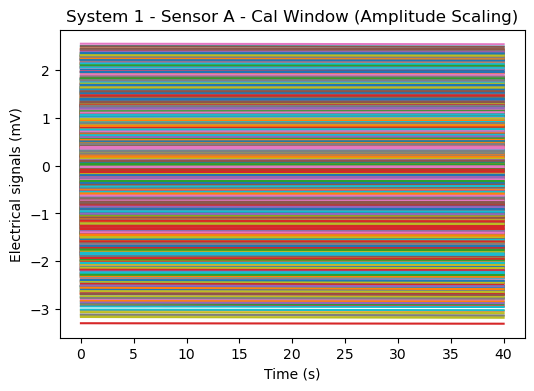

Explained variance for each component:
[9.99989640e-01 1.03240259e-05 2.53585878e-09 1.46176144e-09
 1.19641970e-09 1.11223588e-09 1.07884893e-09 1.04469926e-09
 1.01399563e-09 1.00197716e-09 9.79934006e-10 9.52342398e-10
 9.42709044e-10 9.33002932e-10 9.23663022e-10 9.18679583e-10
 9.00150266e-10 8.87693876e-10 8.81770130e-10 8.76580061e-10
 8.64427245e-10 8.53283835e-10 8.33819720e-10 8.31419786e-10
 8.18389160e-10 8.17900559e-10 7.99371459e-10 7.88936160e-10
 7.81148845e-10 7.77458211e-10 7.71216479e-10 7.63507241e-10
 7.56125785e-10 7.48570354e-10 7.36251669e-10 7.27487564e-10
 7.17565029e-10 7.12864963e-10 7.00863498e-10 6.99615472e-10
 6.81679039e-10]

Explain variance PC1 (%):  99.99896401498889
Explain variance PC2 (%):  0.0010324025890230506

Loadings:
               PC1_Loadings  PC2_Loadings
TimePoint_0      -0.156172      0.266146
TimePoint_1      -0.156172      0.252600
TimePoint_2      -0.156173      0.238938
TimePoint_3      -0.156173      0.225551
TimePoint_4      -0.15

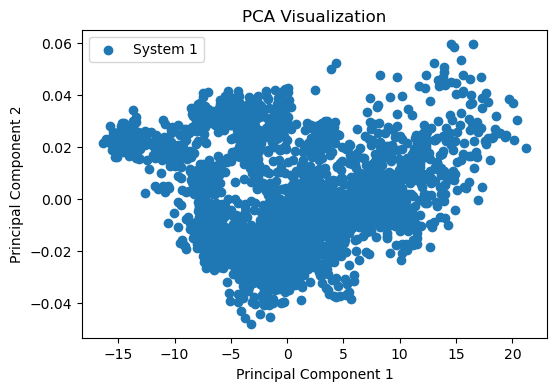

In [13]:
perform_pca_analysis(A1_cal_window, 'System 1 - Sensor A - Cal Window (Amplitude Scaling)')

## 11. Functional PCA

In [14]:
import numpy as np
import pandas as pd
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.projection import FPCA

def perform_functional_pca(data_matrix, title):
    # Convert the data matrix to an FDataGrid object
    fd = FDataGrid(data_matrix=data_matrix, grid_points=data_matrix.columns.astype(float))

    # Apply Functional PCA
    fpca = FPCA(n_components=2)
    fpca.fit(fd)
    pc_scores = fpca.transform(fd)

    # Explain variance ratio
    print('Explain variance PC1 (%): ', fpca.explained_variance_ratio_[0] * 100)
    print('Explain variance PC2 (%): ', fpca.explained_variance_ratio_[1] * 100)

    # --- Loadings ---
    # Extract the principal components (loadings)
    principal_components = fpca.components_

    # --- Scores ---
    # Print the scores to see contributions of each time series to each principal component
    pc_scores_df = pd.DataFrame(pc_scores, columns=['PC1_Scores', 'PC2_Scores'],
                                index=[f'TimeSeries_{data_matrix.index[i]}' for i in range(data_matrix.shape[0])])
    print("PC Scores:\n", pc_scores_df)

    # Identify which time series (functional data object) contributes the most to each principal component
    max_contribution_index_pc1 = np.argmax(np.abs(pc_scores[:, 0]))  # Index of the maximum absolute score in the first PC
    max_contribution_index_pc2 = np.argmax(np.abs(pc_scores[:, 1]))  # Index of the maximum absolute score in the second PC

    print(f'The time series contributing most to PC1 is at index {max_contribution_index_pc1} with TestID {data_matrix.index[max_contribution_index_pc1]}')
    print(f'The time series contributing most to PC2 is at index {max_contribution_index_pc2} with TestID {data_matrix.index[max_contribution_index_pc2]}')

    # --- PCA visualization ---
    fpca.components_.plot()
    plt.title(title)
    plt.legend(['Component 1', 'Component 2'])
    #plt.figure(figsize=(4, 4))
    plt.show()
    fpca.components_[0].plot()
    plt.title(title)
    plt.legend(['Component 1'])
    plt.show()
    fpca.components_[1].plot()
    plt.title(title)
    plt.legend(['Component 2'])
    plt.show()
    #return [data_matrix.index[max_contribution_index_pc1], data_matrix.index[max_contribution_index_pc1]]

/var/folders/_c/wdm33bq11dvflh73ffxrd8z40000gn/T/ipykernel_3074/2456946270.py:4: DeprecationWarning: The module "projection" is deprecated. Please use "dim_reduction"
  from skfda.preprocessing.dim_reduction.projection import FPCA


FPCA CALIBRATION WINDOW

A1_cal_window
Explain variance PC1 (%):  99.9990131329703
Explain variance PC2 (%):  0.000983323863075979
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -511.928238    0.953037
TimeSeries_12414201 -431.878434    0.321238
TimeSeries_12414202 -527.954625    0.837068
TimeSeries_12414203 -512.974359    0.772892
TimeSeries_12414204 -569.118691    0.931376
...                         ...         ...
TimeSeries_12537663 -208.148755   -1.509049
TimeSeries_12539049  -34.663259   -0.605466
TimeSeries_12572832  480.243758    1.049674
TimeSeries_12572836 -104.517339   -0.169876
TimeSeries_12622570  904.125936    1.548010

[3349 rows x 2 columns]
The time series contributing most to PC1 is at index 2683 with TestID 12573667
The time series contributing most to PC2 is at index 1784 with TestID 12529762


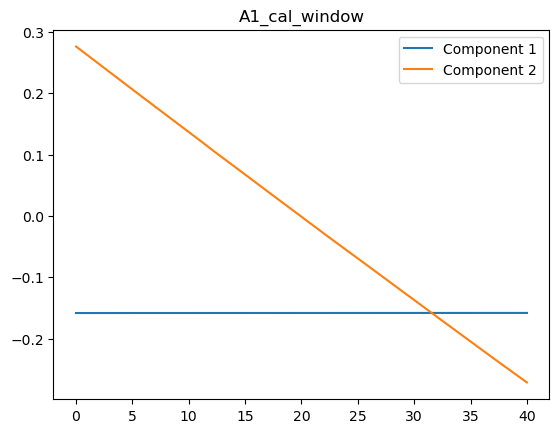

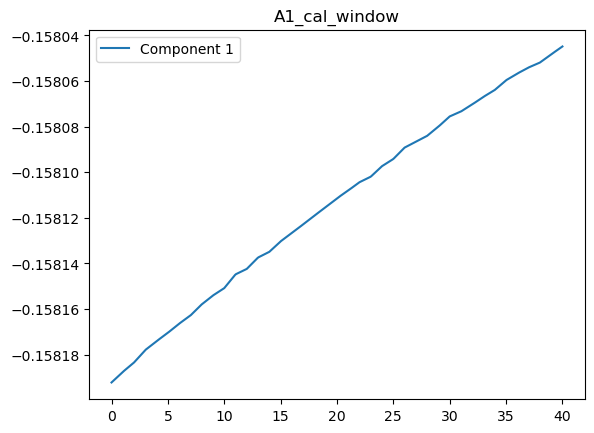

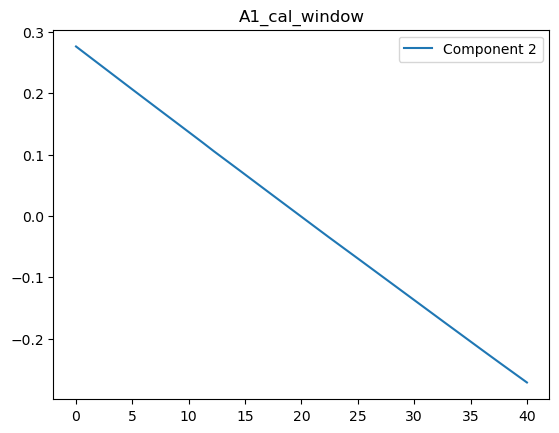

A2_cal_window
Explain variance PC1 (%):  99.99896720273487
Explain variance PC2 (%):  0.0010313754092944136
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995 -235.825302    0.951687
TimeSeries_3551012 -160.090255    1.059807
TimeSeries_3551031 -318.461776    1.481687
TimeSeries_3551047 -241.255275    0.927948
TimeSeries_3551065 -226.014066    1.092449
...                        ...         ...
TimeSeries_3518461  -32.346513    1.134398
TimeSeries_3518462  136.703134    1.715959
TimeSeries_3518621  174.302758    1.346112
TimeSeries_3518680 -420.015961    1.613733
TimeSeries_3518682  -90.111326    1.877941

[7557 rows x 2 columns]
The time series contributing most to PC1 is at index 5376 with TestID 3556087
The time series contributing most to PC2 is at index 6866 with TestID 3567819


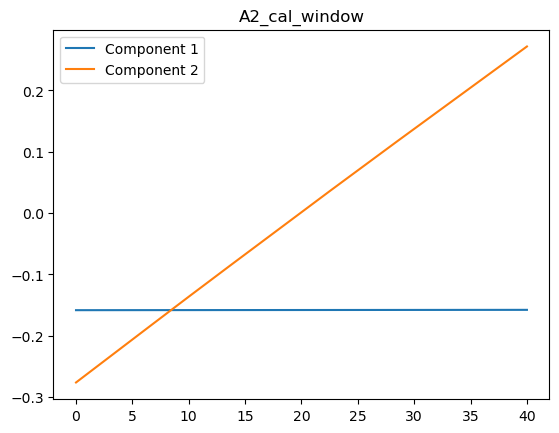

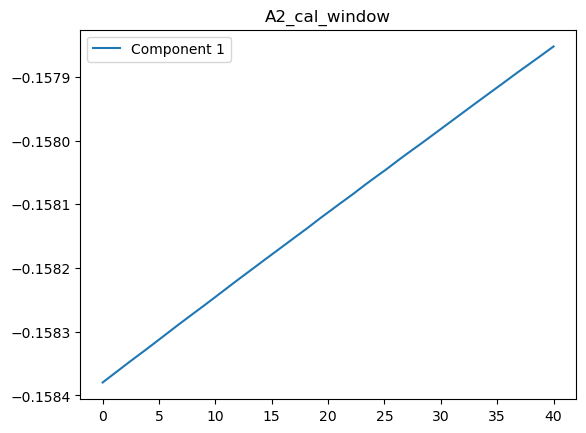

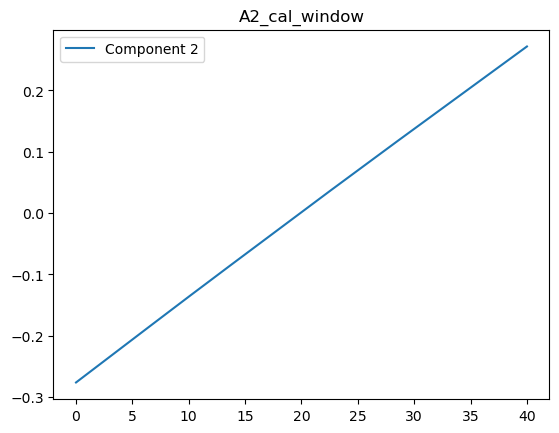

A1_blood_cal_window
Explain variance PC1 (%):  99.99898050746998
Explain variance PC2 (%):  0.001015889851533382
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -466.060746    0.785260
TimeSeries_12414201 -386.010834    0.167402
TimeSeries_12414202 -482.087113    0.666505
TimeSeries_12414203 -467.106836    0.604938
TimeSeries_12414204 -523.251195    0.753668
...                         ...         ...
TimeSeries_12624891  -77.039267   -0.373435
TimeSeries_12624893 -110.343970   -0.341533
TimeSeries_12537663 -162.280840   -1.623983
TimeSeries_12572832  526.111217    1.054466
TimeSeries_12572836  -58.649659   -0.266792

[1916 rows x 2 columns]
The time series contributing most to PC1 is at index 1803 with TestID 12572826
The time series contributing most to PC2 is at index 1882 with TestID 12599845


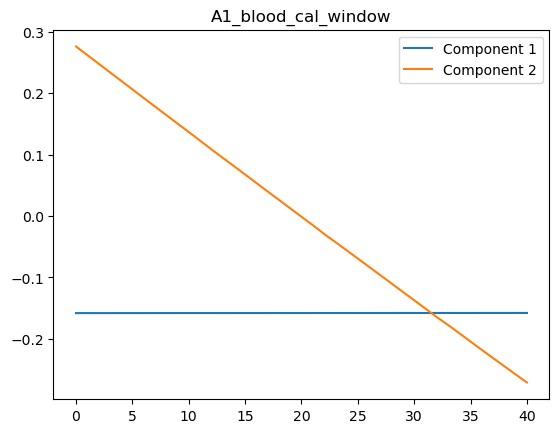

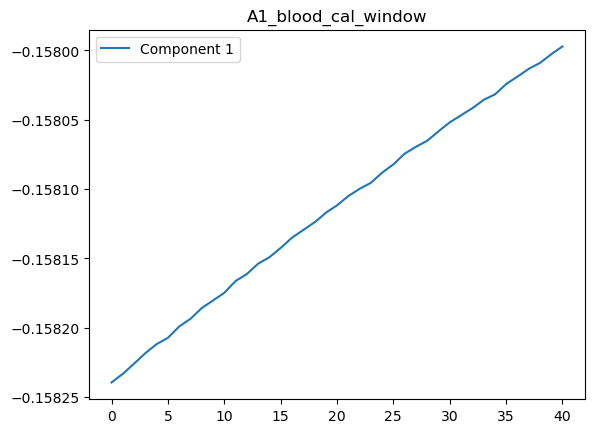

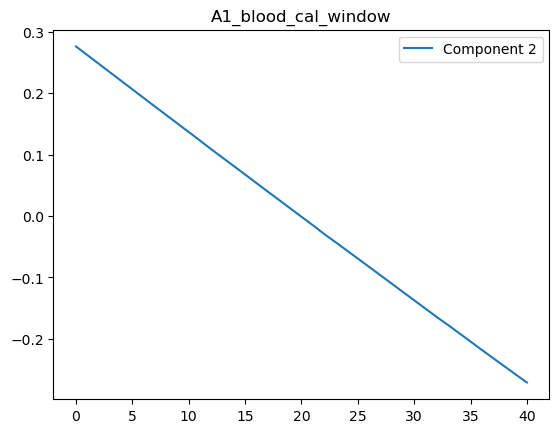

A2_blood_cal_window
Explain variance PC1 (%):  99.99891309468435
Explain variance PC2 (%):  0.0010853905985553794
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995 -208.674911   -1.066048
TimeSeries_3551012 -132.939860   -1.171696
TimeSeries_3551031 -291.311367   -1.598731
TimeSeries_3551047 -214.104885   -1.042480
TimeSeries_3551065 -198.863671   -1.206484
...                        ...         ...
TimeSeries_3518459 -423.064211   -0.586433
TimeSeries_3518460 -448.880823   -1.726757
TimeSeries_3518431  -95.311954   -1.569736
TimeSeries_3518461   -5.196116   -1.242129
TimeSeries_3518462  163.853550   -1.818191

[4745 rows x 2 columns]
The time series contributing most to PC1 is at index 3640 with TestID 3556087
The time series contributing most to PC2 is at index 3090 with TestID 3561214


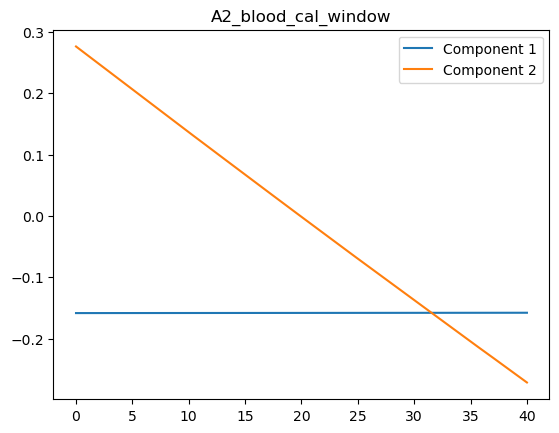

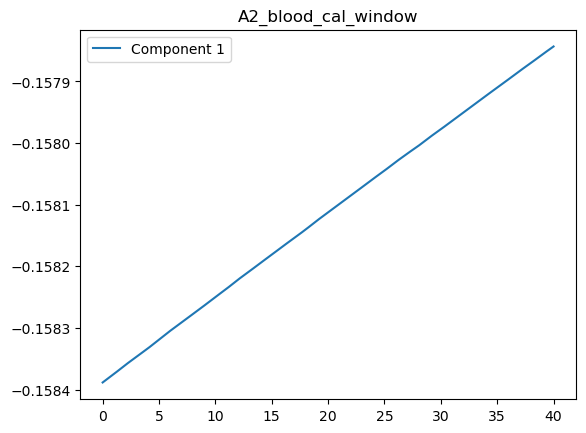

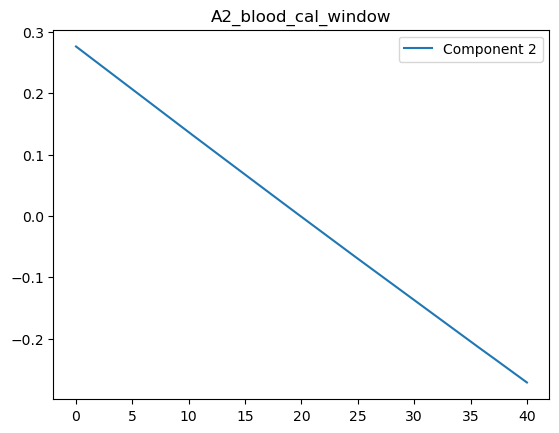

A1_aquous_cal_window
Explain variance PC1 (%):  99.99903631073364
Explain variance PC2 (%):  0.0009600297561910817
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414372 -629.834138    1.125510
TimeSeries_12414373 -595.400743    1.159224
TimeSeries_12414374 -621.052115    1.234430
TimeSeries_12414375 -596.268795    1.117465
TimeSeries_12414377 -647.688876    1.506192
...                         ...         ...
TimeSeries_12470355  438.399068    1.051695
TimeSeries_12470361  543.245842    0.948795
TimeSeries_12470365  -16.820129   -0.712827
TimeSeries_12539049  -95.990977   -0.456802
TimeSeries_12622570  842.798898    1.376544

[1433 rows x 2 columns]
The time series contributing most to PC1 is at index 1042 with TestID 12573667
The time series contributing most to PC2 is at index 828 with TestID 12598120


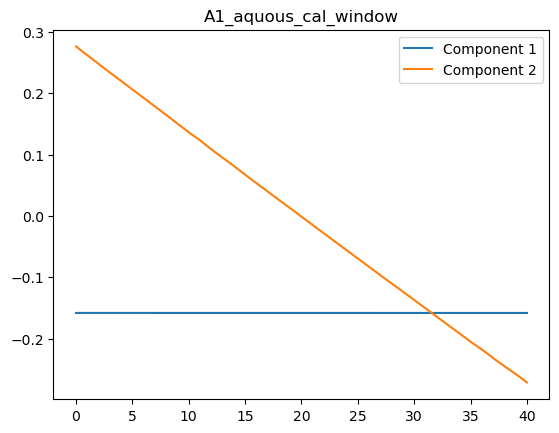

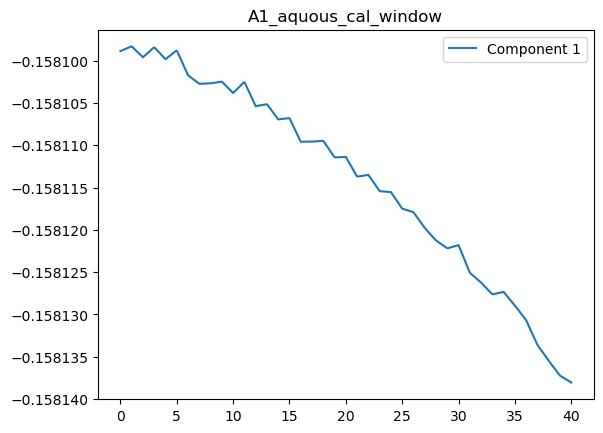

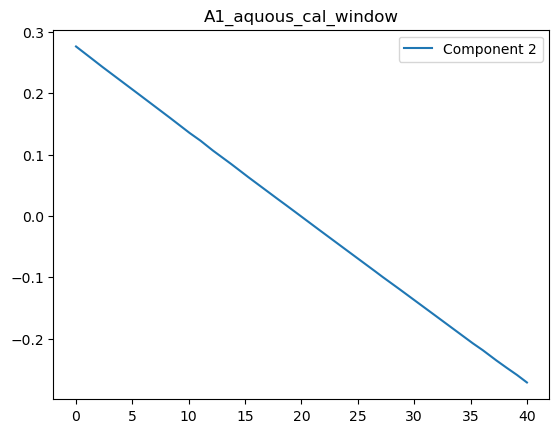

A2_aquous_cal_window
Explain variance PC1 (%):  99.99906140983444
Explain variance PC2 (%):  0.0009372829243855795
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3545083 -666.070043   -0.623496
TimeSeries_3545084 -619.097952   -0.677484
TimeSeries_3545085 -508.368771   -0.958176
TimeSeries_3545086 -579.064911   -0.604515
TimeSeries_3545087 -537.944510   -0.625344
...                        ...         ...
TimeSeries_3518708 -522.360187    0.690964
TimeSeries_3518710  -14.687235    2.108192
TimeSeries_3518621  128.488787    1.181860
TimeSeries_3518680 -465.829962    1.369688
TimeSeries_3518682 -135.925365    1.678184

[2812 rows x 2 columns]
The time series contributing most to PC1 is at index 2134 with TestID 3572300
The time series contributing most to PC2 is at index 2425 with TestID 3567819


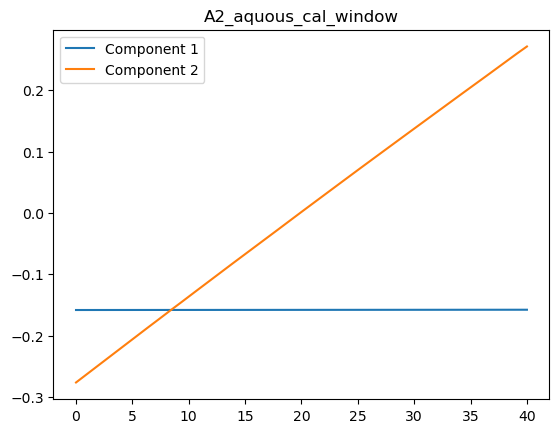

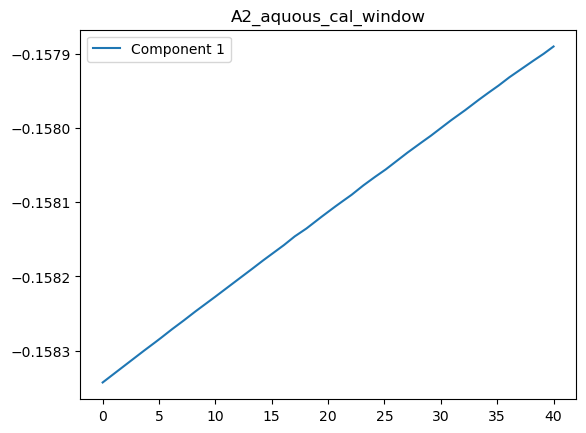

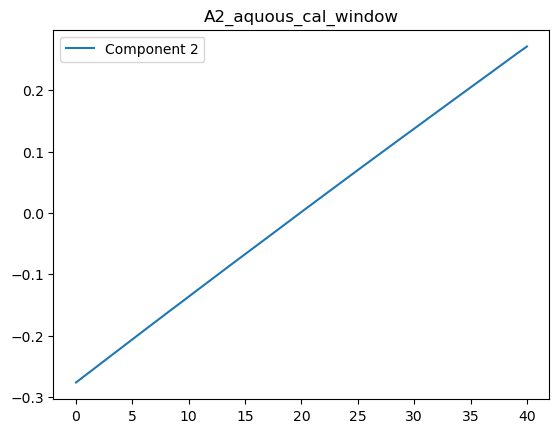

B1_blood_cal_window
Explain variance PC1 (%):  99.99429965213402
Explain variance PC2 (%):  0.005674922119799823
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -280.735614    3.616149
TimeSeries_12414201 -273.224911    3.950660
TimeSeries_12414202 -290.152444    3.608065
TimeSeries_12414203 -307.783676    3.319943
TimeSeries_12414204 -354.889295    3.775659
...                         ...         ...
TimeSeries_12537664 -246.348852    2.054196
TimeSeries_12537668 -172.027863    0.162744
TimeSeries_12624891  119.129034   -2.287491
TimeSeries_12624893   39.841893   -2.576547
TimeSeries_12537663 -137.189694    0.334835

[1944 rows x 2 columns]
The time series contributing most to PC1 is at index 219 with TestID 12544066
The time series contributing most to PC2 is at index 1681 with TestID 12395731


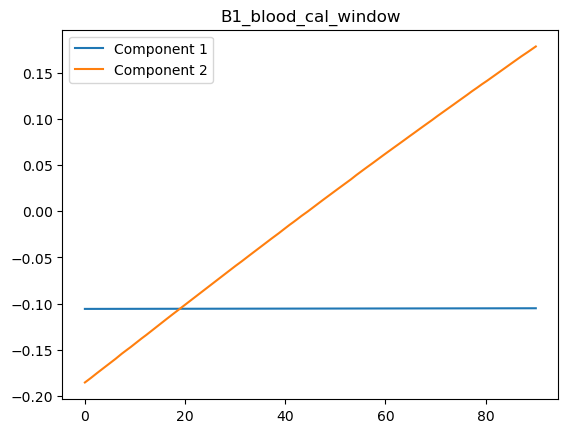

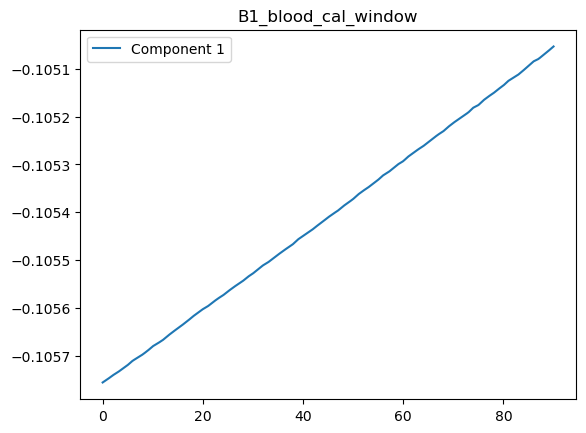

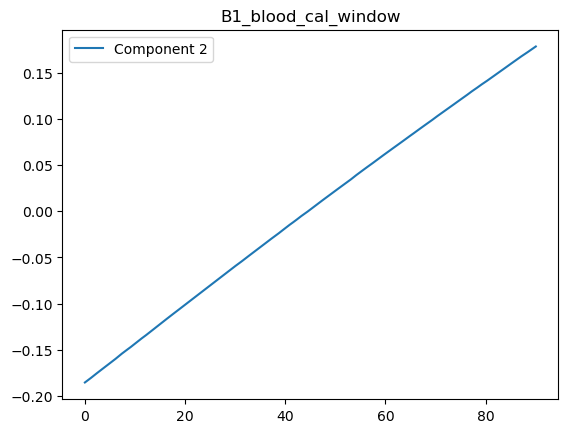

B2_blood_cal_window
Explain variance PC1 (%):  99.99542562829743
Explain variance PC2 (%):  0.004557072231367602
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995  107.834056    0.459404
TimeSeries_3551012   10.283834   -0.876659
TimeSeries_3551031  315.662371   -0.178851
TimeSeries_3551047  189.373785    1.077641
TimeSeries_3551065  104.422050    0.517044
...                        ...         ...
TimeSeries_3518442  585.661882   -5.794548
TimeSeries_3518443  331.730328   -6.788100
TimeSeries_3518444  422.960924   -6.964709
TimeSeries_3518445  254.595743   -6.848450
TimeSeries_3518456  634.698663   -5.835158

[4887 rows x 2 columns]
The time series contributing most to PC1 is at index 418 with TestID 3556268
The time series contributing most to PC2 is at index 2520 with TestID 3567091


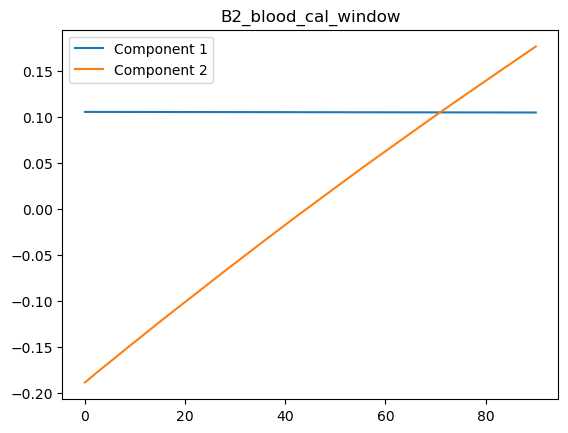

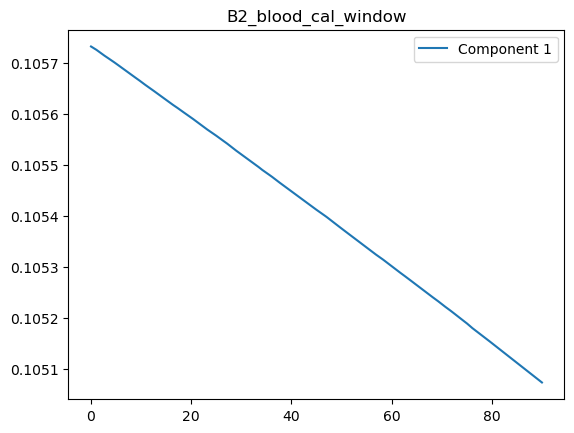

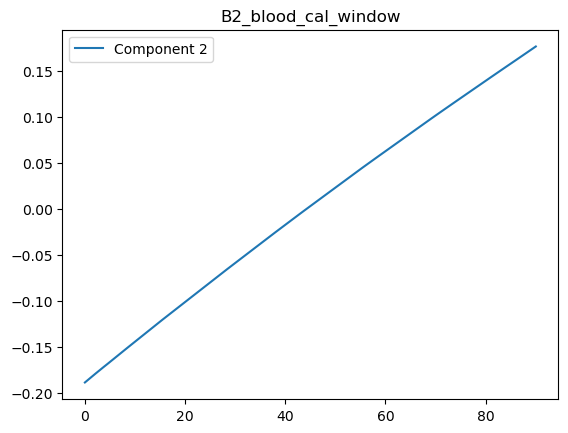

B1_aquous_cal_window
Explain variance PC1 (%):  99.99402628874086
Explain variance PC2 (%):  0.005943245121920711
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414372  370.691377    2.814008
TimeSeries_12414373  373.625801    2.822501
TimeSeries_12414374  407.810233    3.268249
TimeSeries_12414375  405.188164    3.143201
TimeSeries_12414377  365.695460    2.549781
...                         ...         ...
TimeSeries_12470355 -117.699988   -3.399520
TimeSeries_12470361   60.284807   -1.418356
TimeSeries_12470365  125.647578   -0.829341
TimeSeries_12539049  129.244533   -1.050934
TimeSeries_12622570   -7.563354   -1.747086

[1431 rows x 2 columns]
The time series contributing most to PC1 is at index 472 with TestID 12437598
The time series contributing most to PC2 is at index 203 with TestID 12615993


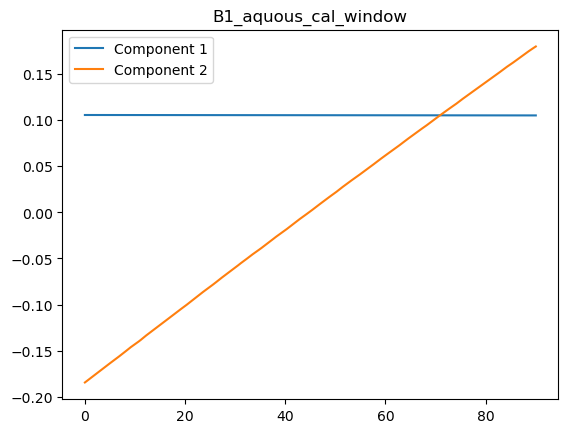

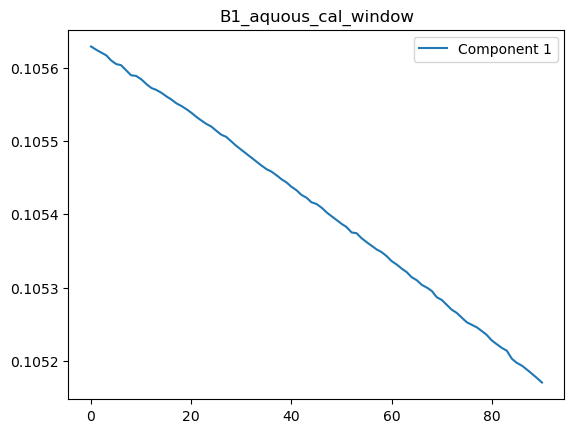

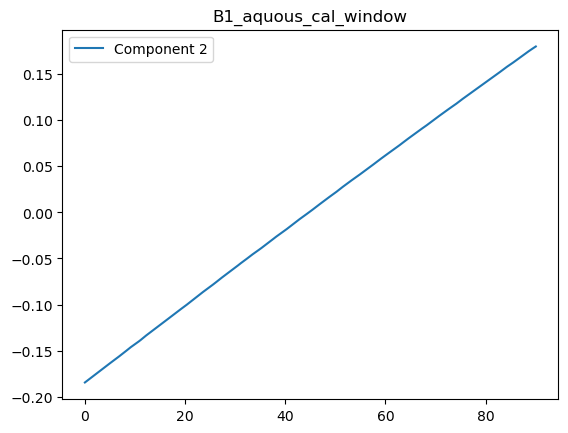

B2_aquous_cal_window
Explain variance PC1 (%):  99.9937450960967
Explain variance PC2 (%):  0.006235825869662593
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3545083  542.405894    3.544643
TimeSeries_3545084  531.495469    3.188401
TimeSeries_3545085  458.332247    2.269276
TimeSeries_3545086  544.628557    3.788931
TimeSeries_3545087  455.449713    3.318268
...                        ...         ...
TimeSeries_3518583  578.831070   -6.471654
TimeSeries_3518675  603.310206   -6.095167
TimeSeries_3518676  425.468952   -5.943599
TimeSeries_3518677  412.730241   -7.148036
TimeSeries_3518678  311.542760   -7.127060

[2852 rows x 2 columns]
The time series contributing most to PC1 is at index 195 with TestID 3548448
The time series contributing most to PC2 is at index 2426 with TestID 3567819


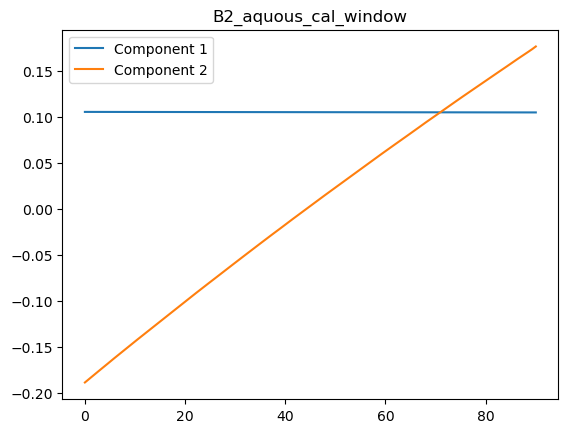

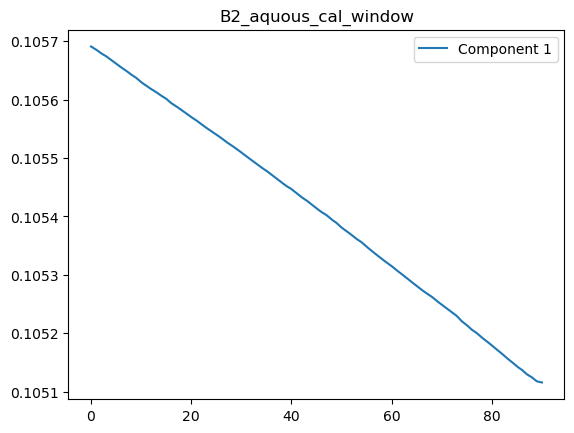

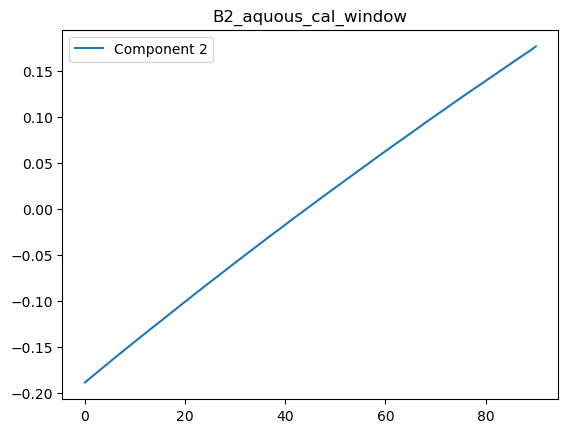

In [15]:
print("FPCA CALIBRATION WINDOW\n")
print("A1_cal_window")
perform_functional_pca(A1_cal_window, "A1_cal_window")
print("A2_cal_window")
perform_functional_pca(A2_cal_window, "A2_cal_window")
print("A1_blood_cal_window")
perform_functional_pca(A1_blood_cal_window, "A1_blood_cal_window")
print("A2_blood_cal_window")
perform_functional_pca(A2_blood_cal_window, "A2_blood_cal_window")
print("A1_aquous_cal_window")
perform_functional_pca(A1_aquous_cal_window, "A1_aquous_cal_window")
print("A2_aquous_cal_window")
perform_functional_pca(A2_aquous_cal_window, "A2_aquous_cal_window")
print("B1_blood_cal_window")
perform_functional_pca(B1_blood_cal_window, "B1_blood_cal_window")
print("B2_blood_cal_window")
perform_functional_pca(B2_blood_cal_window, "B2_blood_cal_window")
print("B1_aquous_cal_window")
perform_functional_pca(B1_aquous_cal_window, "B1_aquous_cal_window")
print("B2_aquous_cal_window")
perform_functional_pca(B2_aquous_cal_window, "B2_aquous_cal_window")

FPCA SAMPLE WINDOW

A1_sample_window
Explain variance PC1 (%):  99.99970787277702
Explain variance PC2 (%):  0.00028858412133830294
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -364.647395   -0.278172
TimeSeries_12414201 -305.940740    0.008041
TimeSeries_12414202 -378.527816   -0.263576
TimeSeries_12414203 -366.840231   -0.228289
TimeSeries_12414204 -410.359033   -0.256567
...                         ...         ...
TimeSeries_12537663 -244.643036    0.394524
TimeSeries_12539049  -40.317360    0.311767
TimeSeries_12572832  311.004241   -0.296740
TimeSeries_12572836 -156.233454   -0.176915
TimeSeries_12622570  713.659362   -0.558689

[3349 rows x 2 columns]
The time series contributing most to PC1 is at index 2818 with TestID 12574513
The time series contributing most to PC2 is at index 531 with TestID 12615995


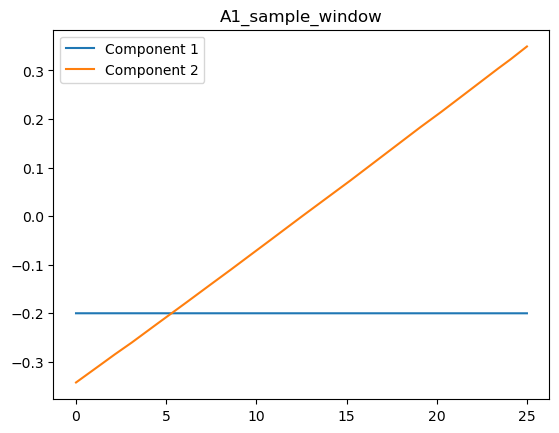

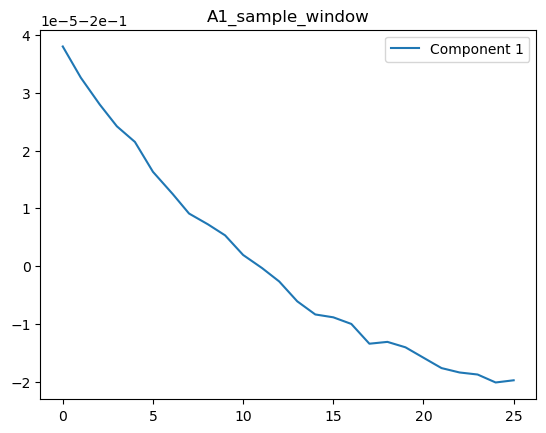

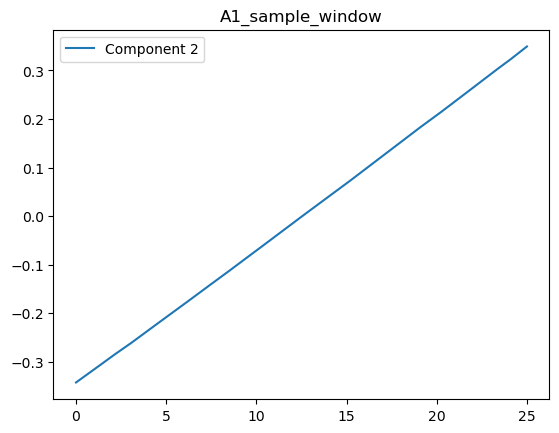

A2_sample_window
Explain variance PC1 (%):  99.9996546870467
Explain variance PC2 (%):  0.0003438679089172303
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995 -220.753608   -0.358918
TimeSeries_3551012 -162.149031   -0.388560
TimeSeries_3551031 -290.496317   -0.635348
TimeSeries_3551047 -225.123388   -0.379117
TimeSeries_3551065 -214.554898   -0.445453
...                        ...         ...
TimeSeries_3518461   37.411729   -0.404046
TimeSeries_3518462  165.837645   -0.328825
TimeSeries_3518621  112.185628   -0.609123
TimeSeries_3518680 -358.617001   -0.839947
TimeSeries_3518682  -98.792968   -0.880271

[7535 rows x 2 columns]
The time series contributing most to PC1 is at index 5354 with TestID 3556087
The time series contributing most to PC2 is at index 4259 with TestID 3561214


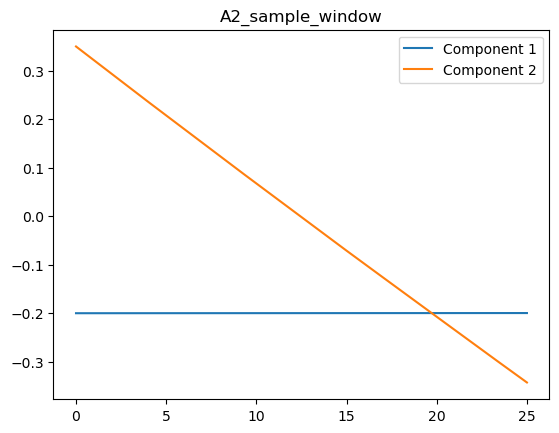

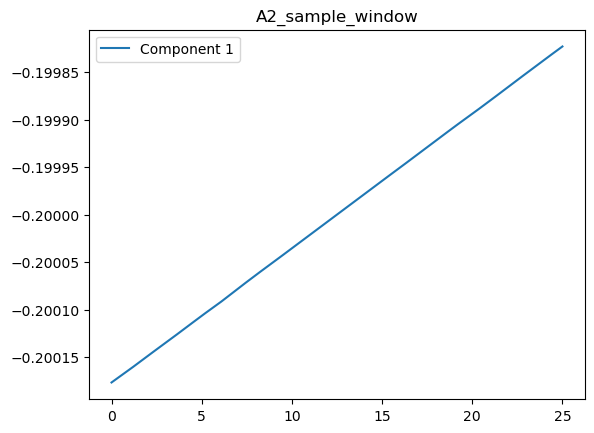

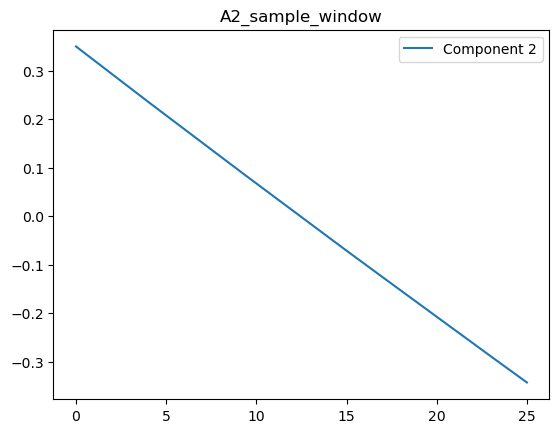

A1_blood_sample_window
Explain variance PC1 (%):  99.99973879651188
Explain variance PC2 (%):  0.00025736521520853135
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -334.872237    0.202924
TimeSeries_12414201 -276.165581   -0.082996
TimeSeries_12414202 -348.752658    0.188245
TimeSeries_12414203 -337.065073    0.153035
TimeSeries_12414204 -380.583875    0.181058
...                         ...         ...
TimeSeries_12624891   -1.556494   -0.139803
TimeSeries_12624893  -23.708409   -0.176332
TimeSeries_12537663 -214.867875   -0.469177
TimeSeries_12572832  340.779399    0.224741
TimeSeries_12572836 -126.458295    0.102622

[1916 rows x 2 columns]
The time series contributing most to PC1 is at index 1706 with TestID 12574513
The time series contributing most to PC2 is at index 462 with TestID 12191350


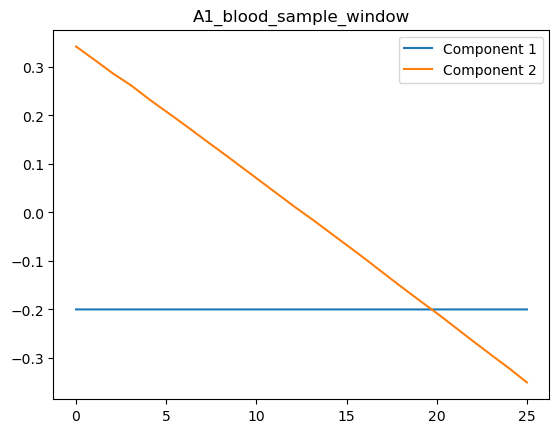

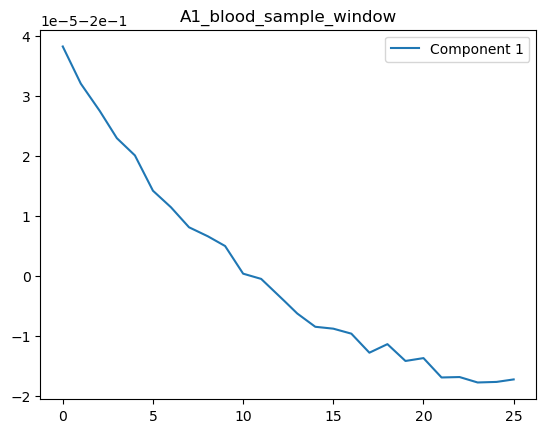

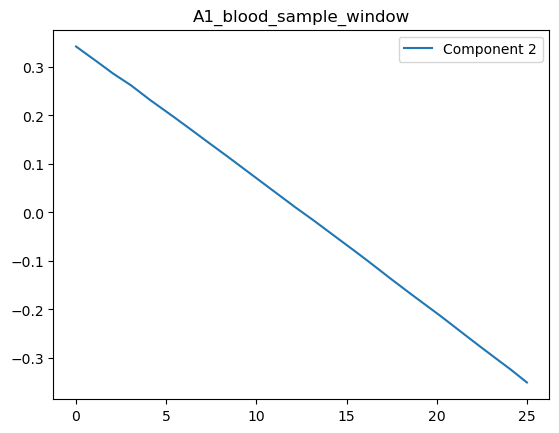

A2_blood_sample_window
Explain variance PC1 (%):  99.99965469619087
Explain variance PC2 (%):  0.00034339799043378393
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995 -210.057056   -0.414404
TimeSeries_3551012 -151.452480   -0.446531
TimeSeries_3551031 -279.799777   -0.687879
TimeSeries_3551047 -214.426837   -0.434412
TimeSeries_3551065 -203.858350   -0.501210
...                        ...         ...
TimeSeries_3518459 -276.049707   -0.098992
TimeSeries_3518460 -305.039845   -0.591231
TimeSeries_3518431 -180.014023   -0.678460
TimeSeries_3518461   48.108279   -0.470432
TimeSeries_3518462  176.534198   -0.400713

[4724 rows x 2 columns]
The time series contributing most to PC1 is at index 3619 with TestID 3556087
The time series contributing most to PC2 is at index 3069 with TestID 3561214


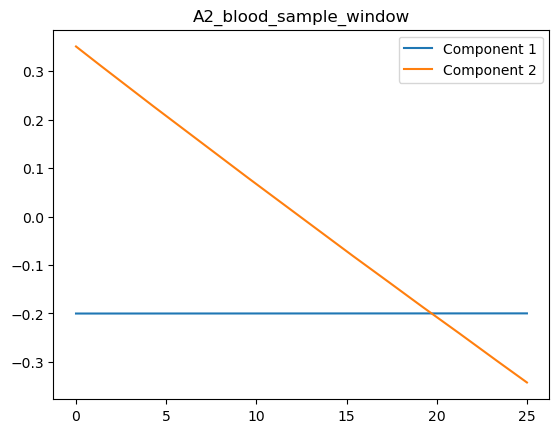

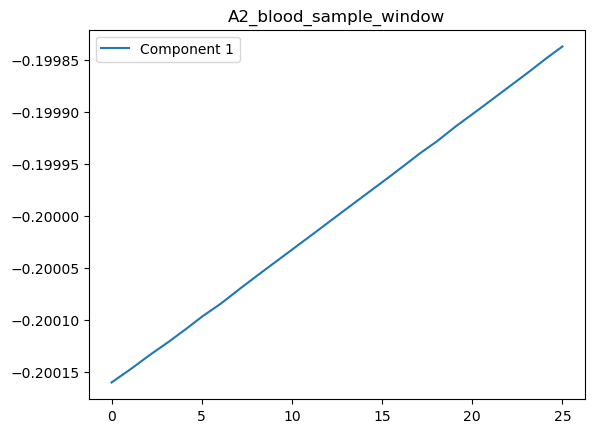

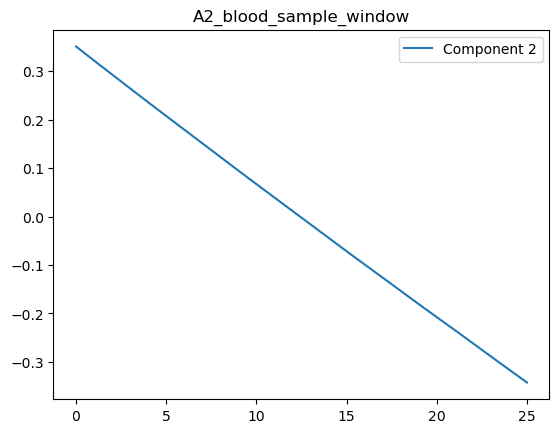

A1_aquous_sample_window
Explain variance PC1 (%):  99.99968073771691
Explain variance PC2 (%):  0.00031599210899645733
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414372 -489.991060   -0.487655
TimeSeries_12414373 -462.556423   -0.512182
TimeSeries_12414374 -482.558618   -0.494353
TimeSeries_12414375 -463.166186   -0.505013
TimeSeries_12414377 -501.402449   -0.648148
...                         ...         ...
TimeSeries_12470355  354.788097   -0.472507
TimeSeries_12470361  436.176632   -0.382653
TimeSeries_12470365  -20.093376    0.305902
TimeSeries_12539049  -80.128410    0.205203
TimeSeries_12622570  673.848396   -0.589146

[1433 rows x 2 columns]
The time series contributing most to PC1 is at index 1042 with TestID 12573667
The time series contributing most to PC2 is at index 191 with TestID 12615995


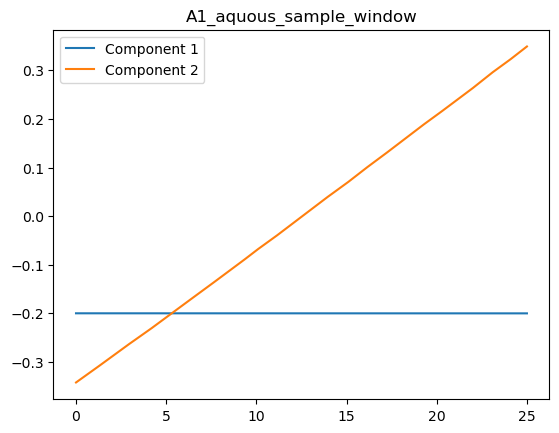

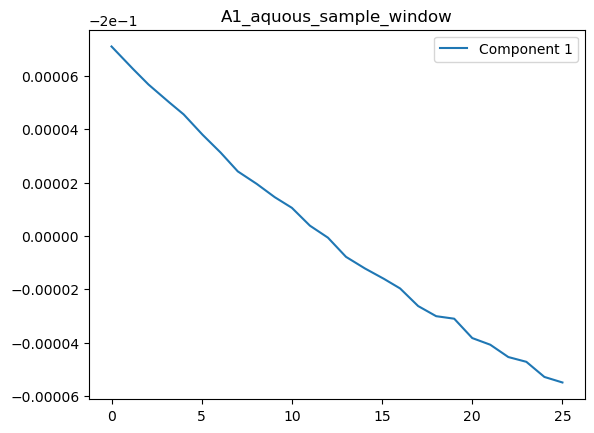

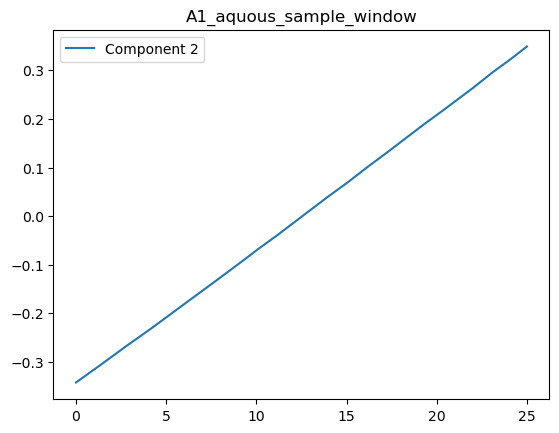

A2_aquous_sample_window
Explain variance PC1 (%):  99.99967265156329
Explain variance PC2 (%):  0.0003265797076880165
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3545083 -515.251009    0.397134
TimeSeries_3545084 -478.296981    0.378717
TimeSeries_3545085 -389.177221    0.536078
TimeSeries_3545086 -447.029801    0.371955
TimeSeries_3545087 -414.501506    0.421247
...                        ...         ...
TimeSeries_3518708 -414.118321   -0.298581
TimeSeries_3518710  -24.859987   -0.723613
TimeSeries_3518621   94.209622   -0.498086
TimeSeries_3518680 -376.593000   -0.743001
TimeSeries_3518682 -116.768966   -0.775585

[2811 rows x 2 columns]
The time series contributing most to PC1 is at index 2133 with TestID 3572300
The time series contributing most to PC2 is at index 1063 with TestID 3569143


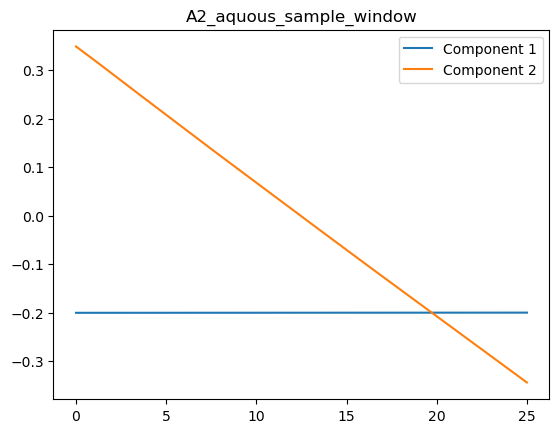

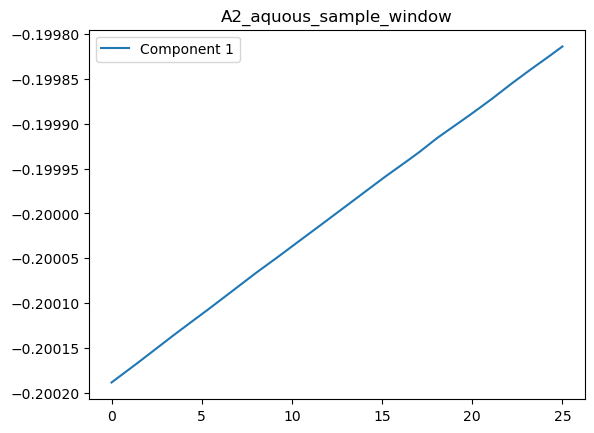

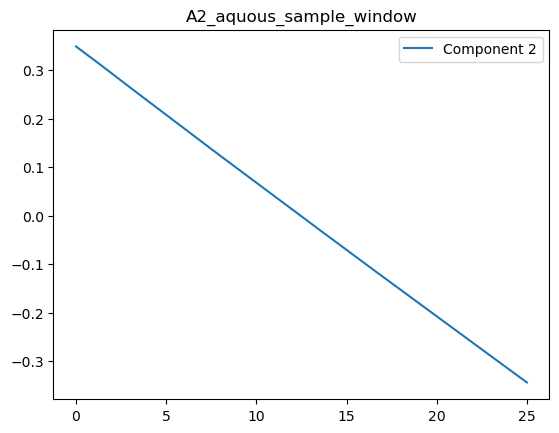

B1_blood_sample_window
Explain variance PC1 (%):  99.99620100809345
Explain variance PC2 (%):  0.0037896630092538724
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -112.216634   -0.147633
TimeSeries_12414201 -110.629548   -0.018918
TimeSeries_12414202 -115.538024   -0.060158
TimeSeries_12414203 -122.847068    0.032328
TimeSeries_12414204 -147.902498   -0.031222
...                         ...         ...
TimeSeries_12537664 -227.197382   -0.078896
TimeSeries_12537668 -188.232317   -0.205236
TimeSeries_12624891  187.188919    1.235715
TimeSeries_12624893  163.116044    1.789061
TimeSeries_12537663 -173.113581   -0.214604

[1944 rows x 2 columns]
The time series contributing most to PC1 is at index 240 with TestID 12546591
The time series contributing most to PC2 is at index 452 with TestID 12191207


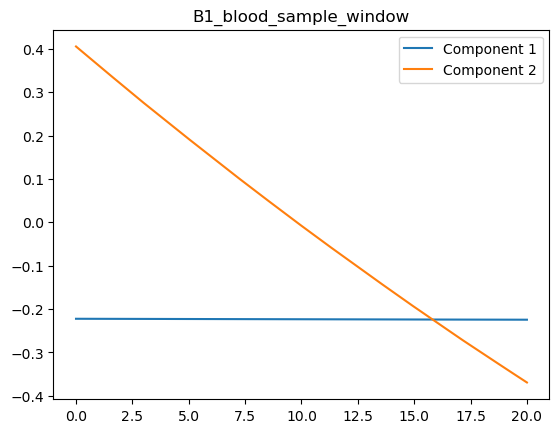

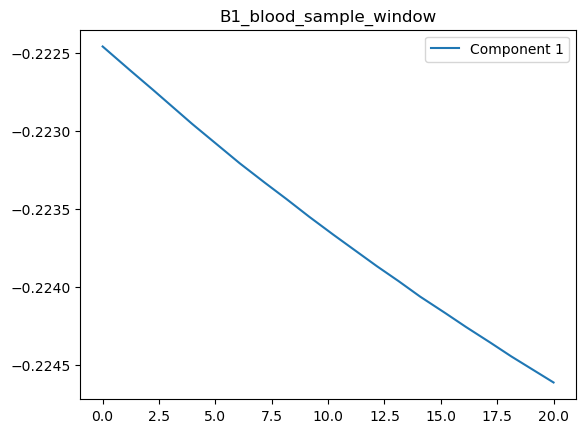

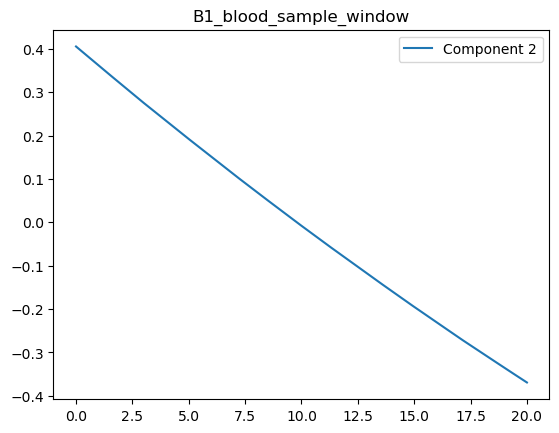

B2_blood_sample_window
Explain variance PC1 (%):  99.99794532419348
Explain variance PC2 (%):  0.002050559207054899
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995  125.469271   -0.522653
TimeSeries_3551012   75.409797   -0.458847
TimeSeries_3551031  216.979992   -0.288089
TimeSeries_3551047  162.389073   -0.421400
TimeSeries_3551065  123.388533   -0.467927
...                        ...         ...
TimeSeries_3518442  128.978857    2.973429
TimeSeries_3518443    8.285297    2.764683
TimeSeries_3518444   51.254308    2.837675
TimeSeries_3518445  -31.406804    3.156691
TimeSeries_3518456  151.983057    2.868753

[4893 rows x 2 columns]
The time series contributing most to PC1 is at index 418 with TestID 3556268
The time series contributing most to PC2 is at index 4868 with TestID 3518458


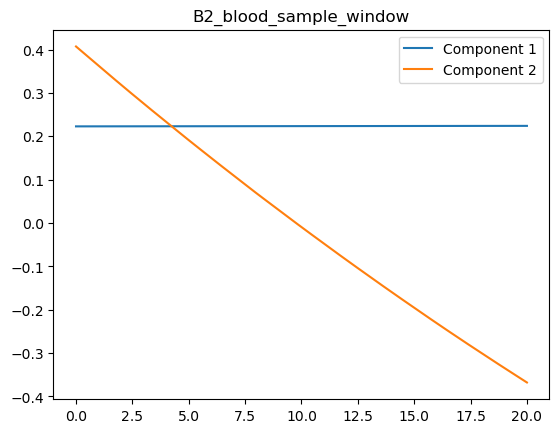

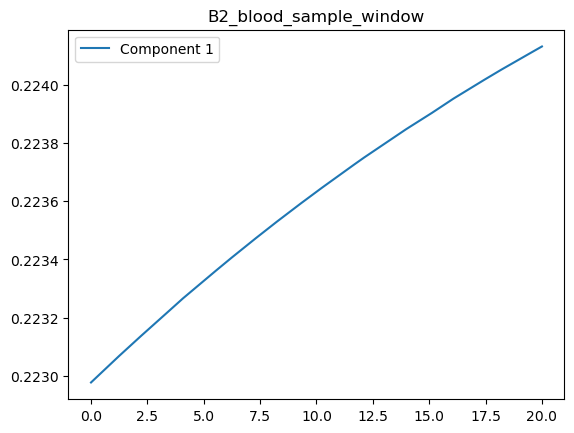

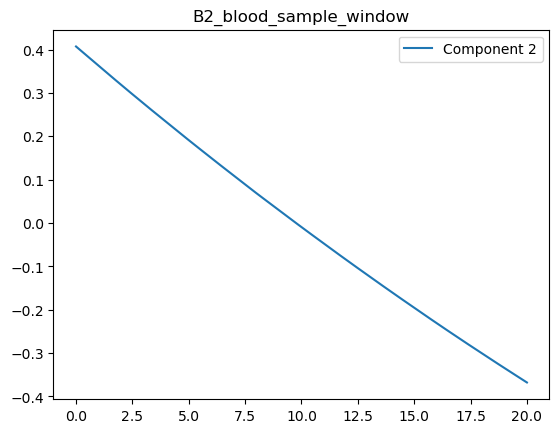

B1_aquous_sample_window
Explain variance PC1 (%):  99.99969297598615
Explain variance PC2 (%):  0.0002958998694525895
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414372  182.961892   -0.373822
TimeSeries_12414373  182.249332   -0.359877
TimeSeries_12414374  200.003408   -0.373952
TimeSeries_12414375  198.678505   -0.351537
TimeSeries_12414377  177.869578   -0.310900
...                         ...         ...
TimeSeries_12470355  -70.960339    0.351319
TimeSeries_12470361   17.593421    0.140385
TimeSeries_12470365   47.188853    0.185141
TimeSeries_12539049   45.405345    0.078044
TimeSeries_12622570  -25.167515    0.127562

[1431 rows x 2 columns]
The time series contributing most to PC1 is at index 472 with TestID 12437598
The time series contributing most to PC2 is at index 1044 with TestID 12623840


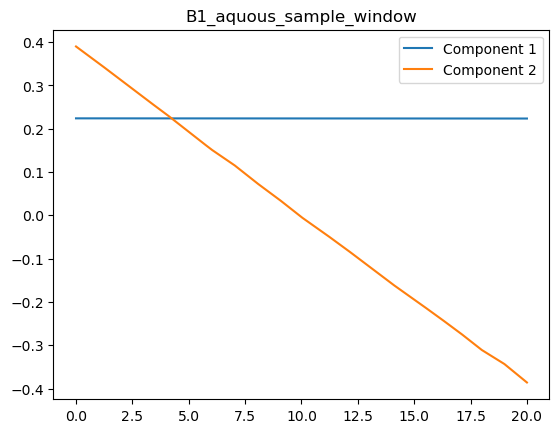

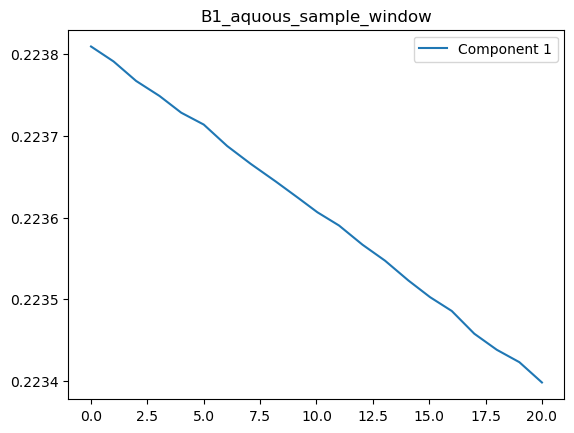

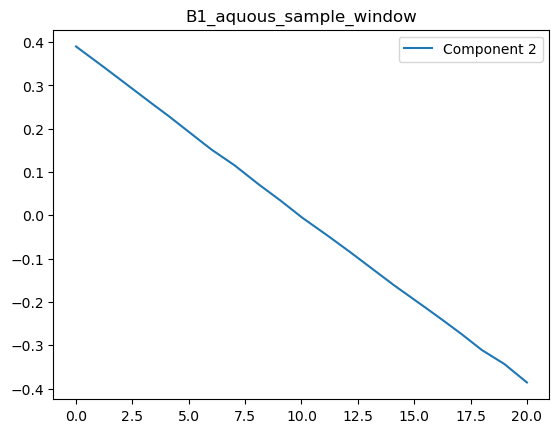

B2_aquous_sample_window
Explain variance PC1 (%):  99.99976387185511
Explain variance PC2 (%):  0.00023388079063263242
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3545083  262.090591   -0.305224
TimeSeries_3545084  255.026071   -0.312076
TimeSeries_3545085  217.728533   -0.154386
TimeSeries_3545086  261.449605   -0.297389
TimeSeries_3545087  220.446807   -0.279763
...                        ...         ...
TimeSeries_3518583  244.638959    0.482587
TimeSeries_3518675  234.850414    0.495165
TimeSeries_3518676  153.581131    0.528870
TimeSeries_3518677  141.872451    0.683167
TimeSeries_3518678   96.559830    0.676792

[2852 rows x 2 columns]
The time series contributing most to PC1 is at index 212 with TestID 3548492
The time series contributing most to PC2 is at index 2823 with TestID 3518631


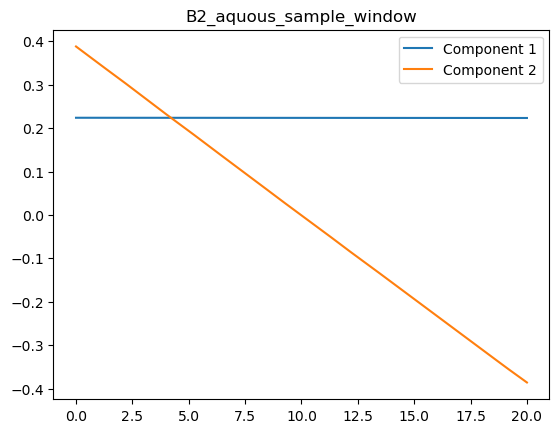

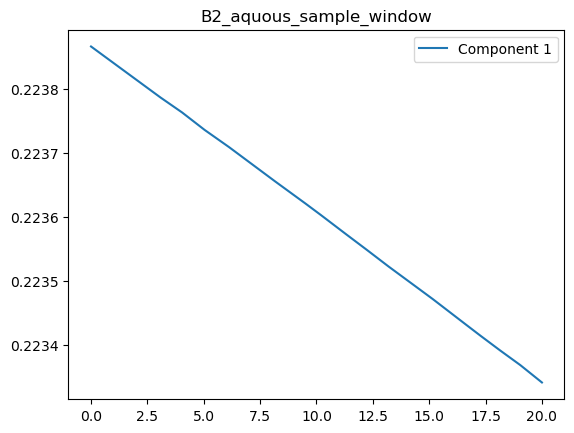

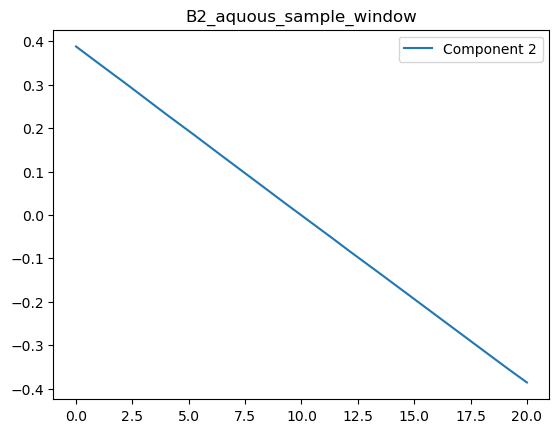

In [16]:
print("FPCA SAMPLE WINDOW\n")
print("A1_sample_window")
perform_functional_pca(A1_sample_window, "A1_sample_window")
print("A2_sample_window")
perform_functional_pca(A2_sample_window, "A2_sample_window")
print("A1_blood_sample_window")
perform_functional_pca(A1_blood_sample_window, "A1_blood_sample_window")
print("A2_blood_sample_window")
perform_functional_pca(A2_blood_sample_window, "A2_blood_sample_window")
print("A1_aquous_sample_window")
perform_functional_pca(A1_aquous_sample_window, "A1_aquous_sample_window" )
print("A2_aquous_sample_window")
perform_functional_pca(A2_aquous_sample_window, "A2_aquous_sample_window")
print("B1_blood_sample_window")
perform_functional_pca(B1_blood_sample_window, "B1_blood_sample_window")
print("B2_blood_sample_window")
perform_functional_pca(B2_blood_sample_window, "B2_blood_sample_window")
print("B1_aquous_sample_window")
perform_functional_pca(B1_aquous_sample_window, "B1_aquous_sample_window")
print("B2_aquous_sample_window")
perform_functional_pca(B2_aquous_sample_window, "B2_aquous_sample_window")

## 12. Verifying waveforms which contributes the most to PC's shape

In [17]:
# PC2 major contributor
A1_Merged[A1_Merged['TestID'] == 12515535].iloc[:,1:18]

,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode


In [18]:
# PC2 major contributor
A1_Merged[A1_Merged['TestID'] == 12371902].iloc[:,1:18]

,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode


In [19]:
A1_Merged[A1_Merged['TestID'] == 12515535].iloc[:,1:18]

,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode


In [20]:
A1_Merged[A1_Merged['TestID'] == 12390613].iloc[:,1:18]

,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode


In [21]:
A2_Merged[A2_Merged['TestID'] == 3561214].iloc[:,1:18]

,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode
4403,Eurotrol L3,2024-03-11 14:39:38,16-23347-40,301133,89,48,187.0,185.4,System 2A,Sensor A,23.2209,NaN,NaN,Success,NoError,NoError,Success


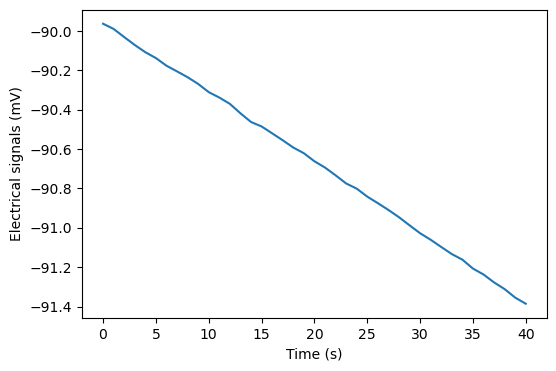

In [22]:
A2_cal_window[A2_cal_window.index == 3561214]
plot_all_time_series(A2_cal_window[A2_cal_window.index == 3561214])